In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
import scipy
import tqdm
import matplotlib.pyplot as plt
import glob

from core import *
from utils import geometry

from scipy.signal import hilbert

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

### Analytic solution to wave equation

In [2]:
# P_i       incident pressure distribution
# rho_0     density
# v_not     velocity
# tau       
# t
# omega     angular frequency
# u         = sin(theta)cos(phi) for point Q
# L         aperture length
# w         element width
# Q         point in field
# lam       wavelength
# m         number of runs (?)
# c_0       constant

In [3]:
def fourier_expression(Q, L, f, m, w, c_0):
    assert Q.shape[-1] == 3, "Q must be a 3D vector [x,y,z] or list of 3D vectors (Nx3)"
    Q = Q.astype(np.float128)
    theta = np.arccos(Q[:,2] / np.linalg.norm(Q, axis=-1))
    theta = np.where(np.linalg.norm(Q) == 0, 0, theta)
    phi = np.arctan2(Q[:,1], Q[:,0])
    u = np.sin(theta) * np.cos(phi)
    exp1 = np.sum(np.array([np.sinc((L * f / c_0) * (u - (m_value * c_0 / f) / w)) for m_value in m]), axis=0)
    exp2 = L * w * w * np.sinc(u * w * f / c_0)
    exp3 = np.sqrt((c_0 / (2 * np.pi * np.linalg.norm(Q, axis=-1))))
    return exp1 * exp2 * exp3

def exponential_expression(rho_0, v_0, tau, t, omega_c):
    t = t.astype(np.float128)
    exp1 = rho_0 * v_0 * np.exp(-t / tau) * np.cos(-omega_c * t)
    H = np.heaviside(t, 1)
    return exp1 * H

def convolution(fourier, exponential):
    signals = [np.convolve(exponential, fourier[i,:], mode='same') for i in range(fourier.shape[0])]
    return np.array(signals)

def compute_signal(q, L, F, m, w, c_0, rho_0, v_0, tau, t, omega_c):
    fourier = np.fft.ifft(np.array([fourier_expression(q, L, freq, m, w, c_0) for freq in F]).T, axis=-1)
    exponential = exponential_expression(rho_0, v_0, tau, t, omega_c)
    return convolution(fourier, exponential)

def extract_pressure(signal, timestep, Q):
    distance = np.linalg.norm(Q, axis=-1)
    sigs = [np.abs(np.real(signal[i,(np.round(timestep * distance[i])).astype(np.int32)])) for i in range(len(distance))]
    return np.array(sigs)

In [24]:
L = 1e-2
f = 1000000
m = [-2,-1,0,1,2]
w = L / 128 # 32 element transducer
c_0 = 1500
F = np.linspace(f * 0.95, f * 1.05, 1)
rho_0 = 1000
v_0 = 5e-8
tau = 1
omega_c = 1
t = np.linspace(0, 20, 200) # Time input here (20) would = t/f [seconds]
timestep = (t[-1]-t[0]) / f
time_duration = timestep * len(t)

Q = np.meshgrid(np.linspace(-0.02, 0.02, 64), np.linspace(0, 0, 1), np.linspace(0, 0.01, 64), indexing='ij')
Q = np.stack((Q[0].ravel(), Q[1].ravel(), Q[2].ravel())).T

In [29]:
L = 10e-3
f = 1000000
m = [-2,-1,0,1,2]
w = L / 32 # 32 element transducer
c_0 = 1500
F = np.linspace(f * 0.95, f * 1.05, 50)
rho_0 = 1000
v_0 = 5e-8
tau = 1
omega_c = 1
t = np.linspace(0, 20, 200) # Time input here (20) would = t/f [seconds]
timestep = (t[-1]-t[0]) / f
time_duration = timestep * len(t)

dim = 255
Q = np.meshgrid(np.linspace(-0.02, 0.02, dim), np.linspace(0, 0, 1), np.linspace(0, 0.04, dim), indexing='ij')
Q = np.stack((Q[0].ravel(), Q[1].ravel(), Q[2].ravel())).T

/tmp/ipykernel_3980770/1598527354.py:4: RuntimeWarning: invalid value encountered in true_divide
  theta = np.arccos(Q[:,2] / np.linalg.norm(Q, axis=-1))
/tmp/ipykernel_3980770/1598527354.py:10: RuntimeWarning: divide by zero encountered in true_divide
  exp3 = np.sqrt((c_0 / (2 * np.pi * np.linalg.norm(Q, axis=-1))))
/tmp/ipykernel_3980770/4002254777.py:10: UserWarning: Casting input data from float128 to float64 for imshow.
  plt.savefig('pressure_field.png', dpi=300)
/home/trevor/miniconda3/envs/musik/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Casting input data from float128 to float64 for imshow.
  fig.canvas.print_figure(bytes_io, **kw)


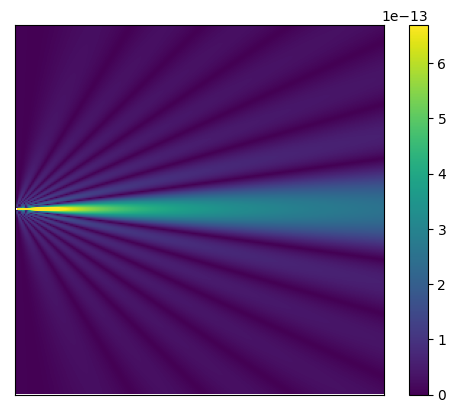

In [60]:
ps = []

sig = compute_signal(Q, L, F, m, w, c_0, rho_0, v_0, tau, t, omega_c)
ps = extract_pressure(sig, timestep, Q)

plt.imshow(np.real(np.array(ps)).reshape(dim, dim), vmin=0, vmax=np.percentile(np.where(np.isnan(ps), 0, ps), 99.9))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.savefig('pressure_field.png', dpi=300)

In [73]:
ps_square = np.array(ps).reshape(dim, dim)
new_img = np.zeros_like(ps_square)

for i in range(-32,32):
    if i < 0:
        new_img = new_img + np.pad(ps_square, ((0,-i),(0,0)))[-i:]
    elif i > 0:
        new_img = new_img + np.pad(ps_square, ((i,0),(0,0)))[:-i]
    else:
        new_img = new_img + ps_square

/home/trevor/miniconda3/envs/musik/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Casting input data from float128 to float64 for imshow.
  func(*args, **kwargs)
/home/trevor/miniconda3/envs/musik/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Casting input data from float128 to float64 for imshow.
  fig.canvas.print_figure(bytes_io, **kw)


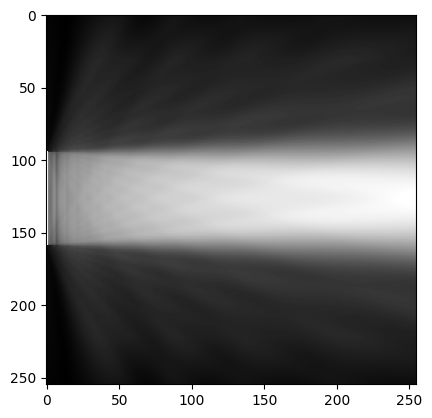

In [75]:
plt.imshow(new_img, vmin=0, vmax=np.percentile(np.where(np.isnan(new_img), 0, new_img), 99.9), cmap='gray')

/tmp/ipykernel_3980770/1598527354.py:4: RuntimeWarning: invalid value encountered in true_divide
  theta = np.arccos(Q[:,2] / np.linalg.norm(Q, axis=-1))
/tmp/ipykernel_3980770/1598527354.py:10: RuntimeWarning: divide by zero encountered in true_divide
  exp3 = np.sqrt((c_0 / (2 * np.pi * np.linalg.norm(Q, axis=-1))))
/home/trevor/miniconda3/envs/musik/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


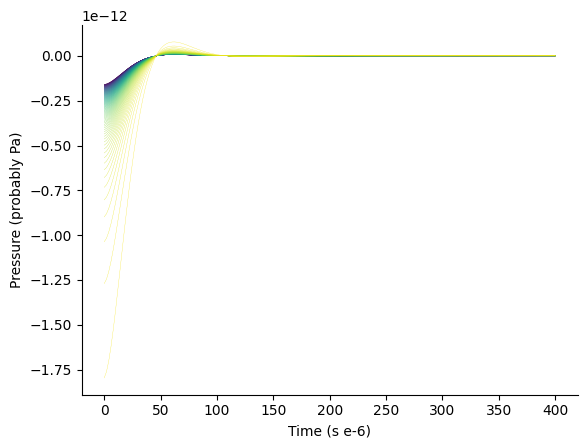

In [23]:
cmap = plt.get_cmap('viridis')

Q = np.array([np.array([0, 0, i]) for i in np.linspace(0, 0.1, 128)])
sigs = compute_signal(Q, L, F, m, w, c_0, rho_0, v_0, tau, t, omega_c)

plt.xlabel('Time (s e-6)')
plt.ylabel('Pressure (probably Pa)')

for i,signal in enumerate(sigs[::-1]):
    j = 31-i
    j = 0
    plt.plot(t*timestep * 1000000+j*4, signal + j*2e-15, color=cmap(i / len(sigs)), alpha=1, linewidth=0.2)
    
plt.gca().spines[['right', 'top']].set_visible(False)
# plt.savefig('signal.png', pad_inches=0.1 ,dpi=300)